In [292]:
import sys
sys.path.insert(0, '..')
# Allows plots to be zoomed in, etc
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import time

from Configuration import Configuration
from InterneuronPoolOpt import InterneuronPool
from SynapsesFactory import SynapsesFactory

In [310]:
def simulator(numberRC, duration, current, gkf, gks, aq, bq, an, bn):

    conf = Configuration('confuchiyama.rmto')

    # Number of cells
    idx = np.where(conf.confArray['f0']=='Number_RC_ext')[0][0]
    conf.confArray['f1'][idx] = numberRC
    
    # Duration of simulation
    conf.simDuration_ms = duration
    
    idx = np.where(conf.confArray['f0']=='threshold:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 18.9089
    conf.confArray['f2'][idx] = 18.9089

    # Ks
    idx = np.where(conf.confArray['f0']=='gmax_Kf:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = gkf
    idx = np.where(conf.confArray['f0']=='gmax_Ks:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = gks
    idx = np.where(conf.confArray['f0']=='alpha_q:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = aq
    idx = np.where(conf.confArray['f0']=='beta_q:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = bq
    idx = np.where(conf.confArray['f0']=='alpha_n:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = an
    idx = np.where(conf.confArray['f0']=='beta_n:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = bn

    ## Morphology
    idx = np.where(conf.confArray['f0']=='d@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 27
    conf.confArray['f2'][idx] = 27
    idx = np.where(conf.confArray['f0']=='l@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 218.2168
    conf.confArray['f2'][idx] = 218.2168
    idx = np.where(conf.confArray['f0']=='res@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 700
    conf.confArray['f2'][idx] = 700
    idx = np.where(conf.confArray['f0']=='membCapac_IN')[0][0]
    conf.confArray['f1'][idx] = 10
    
    pools = dict()
    pools[0] = InterneuronPool(conf, 'RC', 'ext')

    Syn = SynapsesFactory(conf, pools)

    t = np.arange(0.0, conf.simDuration_ms, conf.timeStep_ms)

    RC_mV = np.zeros_like(t)
    m = []
    h = []
    n = []
    q = []
    for i in xrange(0, len(t)):
        if t[i]>10 and t[i]<10.2:
            for j in xrange(len(pools[0].unit)):
                pools[0].iInjected[j] = current
        else:
            for j in xrange(len(pools[0].unit)):
                pools[0].iInjected[j] = 0
        pools[0].atualizeInterneuronPool(t[i]) # RC pool
        # Record temporal behavior of q(t)
        n.append(pools[0].unit[0].compartment[0].Channels[0].condState[0].value)
        q.append(pools[0].unit[0].compartment[0].Channels[1].condState[0].value)
        m.append(pools[0].unit[0].compartment[0].Channels[2].condState[0].value)
        h.append(pools[0].unit[0].compartment[0].Channels[2].condState[1].value)
        RC_mV[i] = pools[0].unit[0].v_mV[0]

    pools[0].listSpikes()

    return RC_mV, m, h, n, q, t

In [315]:
nRC = 1
t = 150
i = 250

gks = 9000000
gkf = 3300
aq = 0.002
bq = 0.02
an = 6
bn = 0.5

RCMembrane, m, h, n, q, t = simulator(nRC, t, i, gkf, gks, aq, bq, an, bn)

Interneuron Pool of RC ext built
All the 0 synapses were built
Synaptic Noise on RC_ext built
All the 1 synaptic noises were built


<IPython.core.display.Javascript object>


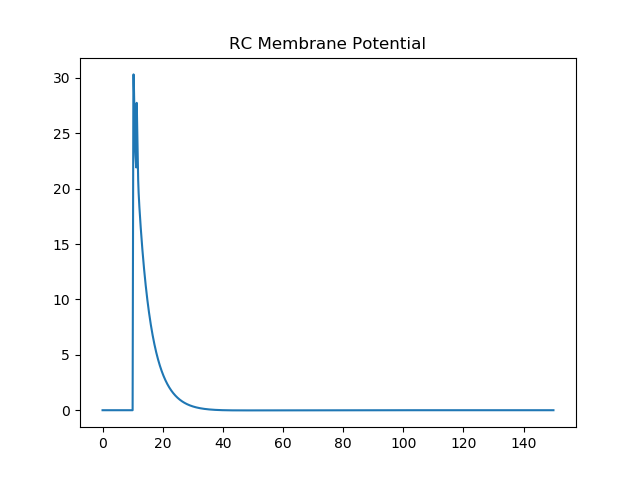

<IPython.core.display.Javascript object>


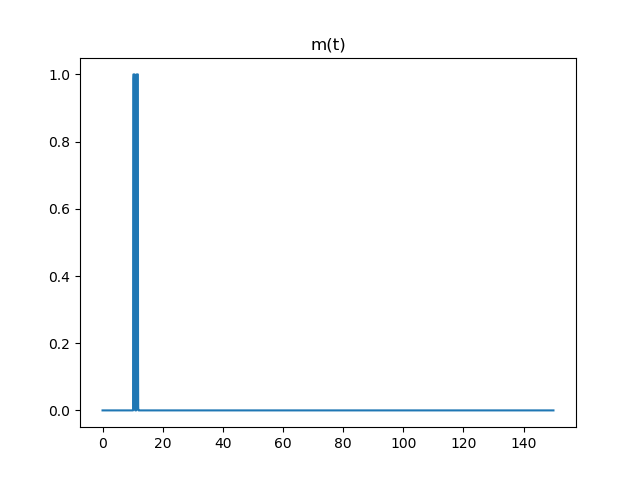

<IPython.core.display.Javascript object>


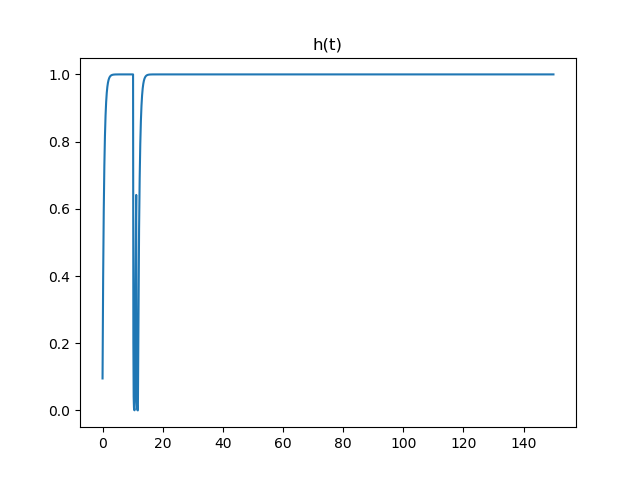

<IPython.core.display.Javascript object>


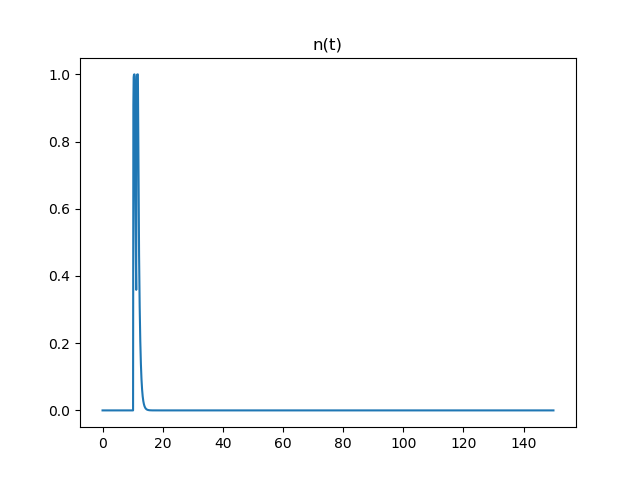

<IPython.core.display.Javascript object>


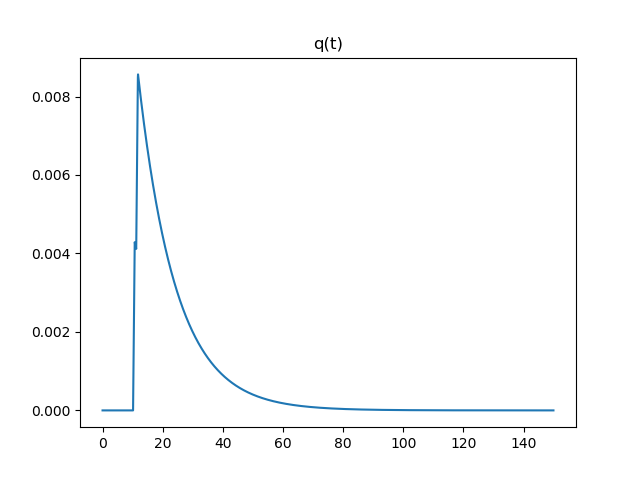

In [317]:
plt.figure()
plt.plot(t, RCMembrane)
plt.title('RC Membrane Potential')
plt.show()

plt.figure()
plt.plot(t, m)
plt.title('m(t)')
plt.show()

plt.figure()
plt.plot(t, h)
plt.title('h(t)')
plt.show()

plt.figure()
plt.plot(t, n)
plt.title('n(t)')
plt.show()

plt.figure()
plt.plot(t, q)
plt.title('q(t)')
plt.show()